In [104]:
import requests

In [105]:
import json

### Get file list

I have a list of simulated files stored in an OpenStack Object Storage container that is world-readable.

Download that file, split by lines and parallelize it into an RDD

In [106]:
# The code was removed by DSX for sharing.

In [107]:
filelist_txt = r.text

In [108]:
fl_rdd = sc.parallelize(filelist_txt.split('\n')[:-1], 20)

In [109]:
fl_rdd.count()

1000

#### Quick Inspection.

Take a look at the first row. Each line is JSON with a 'file_name', 'uuid' and 'signal_classification'. 

Then I show you the different "signal_classifications" we have. 

In [110]:
fl_rdd.first()

u'{"file_name": "00cb8c44-2289-445b-be14-14dfd7c6b2da.dat", "signal_classification": "narrowbanddrd", "uuid": "00cb8c44-2289-445b-be14-14dfd7c6b2da"}'

In [111]:
fl_rdd2 = fl_rdd.map(lambda row: json.loads(row))

In [112]:
fl_rdd2.cache()

PythonRDD[38] at RDD at PythonRDD.scala:48

In [113]:
fl_df2 = fl_rdd2.toDF()

In [114]:
fl_df2.groupBy('signal_classification').count().show(10, False) #there are 4 classes

+---------------------+-----+
|signal_classification|count|
+---------------------+-----+
|squiggle             |250  |
|noise                |250  |
|narrowbanddrd        |250  |
|narrowband           |250  |
+---------------------+-----+



### Make a single spectrogram

I'll take one of the file names and then get the actual data from another Object Storage container that is world readable. 

In [115]:
some_datafilename = fl_rdd2.take(1)

GET the data

In [116]:
base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'
container = 'simsignals_basic'
fname = some_datafilename[0]['file_name']
r = requests.get('{}/{}/{}'.format(base_url, container, fname))

In [117]:
fname

u'00cb8c44-2289-445b-be14-14dfd7c6b2da.dat'

In [118]:
r.status_code

200

I have built some helpful tools to read the data in the `ibmseti` package. However, you may be interested
in seeing the code I used to perform the DFT and spectrogram. It's quite simple. The SimCompamp class just wraps a few Numpy calls.

In [119]:
#!pip install --user --upgrade ibmseti
#you might want to see the code here
#https://github.com/ibm-cds-labs/ibmseti/blob/master/ibmseti/simcompamp.py

In [120]:
import ibmseti

Create the SimCompamp object and call `get_spectrogram`. Voila! 


In [121]:
aca = ibmseti.compamp.SimCompamp(r.content)  

In [122]:
aca.data[0:100]

'\xee\xf8\xea\x12\xfd\x14\xfb\x00\xf1\xfb\xfe\x0c\x11\x00\x0f\xfe\xfd\xfc\xf6\xfb\t\t\xf3\xf6\xf7\x19\x10\xff\xf5\x03\xdb\x19\xf5\x08\x00\x02\xf1!\xf6\xf0\xfc\xfc\x0b\xf1\xea\x13\xfa\xf6\x0b\xf6\xf1\x01\x00\xfc\x06\xf0\xfa\xeb\x07\x01\r\xf7\xf6\n\x00\x05\xf6\xdb\x04\xfb\xf0\x03\xfd\xe9\x00\xfb\xf5\x0b\xf8\xfc\xf0\x12\xf7\x00\xfd\r\x11\x0b\xf1\x02\xf3\x17\xfb\xf2\x00\x07\x07\x0b\n\xfa'

is aca data 16-bit (2 bytes)?

In [123]:
import struct
raw_data = struct.unpack('h'*50, aca.data[0:100])
print(raw_data)

(-1810, 4842, 5373, 251, -1039, 3326, 17, -497, -771, -1034, 2313, -2317, 6647, -240, 1013, 6619, 2293, 512, 8689, -3850, -772, -3829, 5098, -2310, -2549, 497, -1024, -4090, -5126, 263, -2291, 2806, 1280, -9226, -1276, 1008, -5635, -1280, 3061, -776, 4848, 247, 3581, 2833, 753, 6131, -3333, 1792, 2823, -1526)


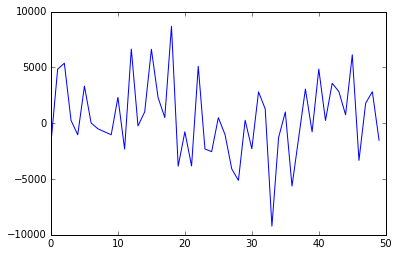

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(raw_data)

In [125]:
cd = aca.complex_data()

In [126]:
cd[0:5]

array([-18. -8.j, -22.+18.j,  -3.+20.j,  -5. +0.j, -15. -5.j], dtype=complex64)

In [127]:
spec = aca.get_spectrogram()

In [129]:
type(spec)

numpy.ndarray

In [130]:
np.shape(spec)

(129, 6144)

In [135]:
spec[0:2]

array([[ 4109053.        ,  2134059.12277987,  2147139.87889133, ...,
         3025109.74691223,   827470.57569989,  1812935.89898772],
       [ 1972800.        ,  1813795.51987834,  1483877.27087657, ...,
         3234046.27493538,   652217.96608314,  1864318.97276393]])

In [136]:
np.log(spec[0:2])

array([[ 15.22870315,  14.57353642,  14.57964723, ...,  14.92245793,
         13.62612883,  14.41045813],
       [ 14.49496441,  14.41093218,  14.210169  , ...,  14.98924463,
         13.38813409,  14.43840638]])

In [128]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

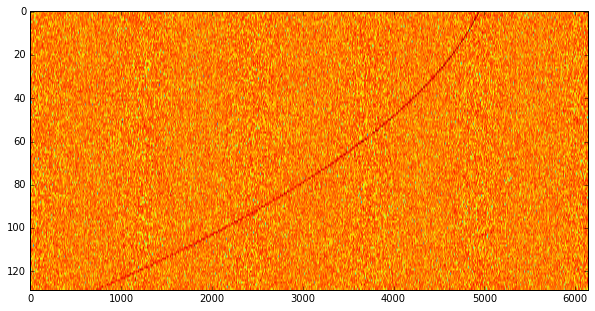

In [138]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])

window size = 129  
N = 6144

### NarrowbandDRD

In [140]:
base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'
container = 'simsignals_basic'

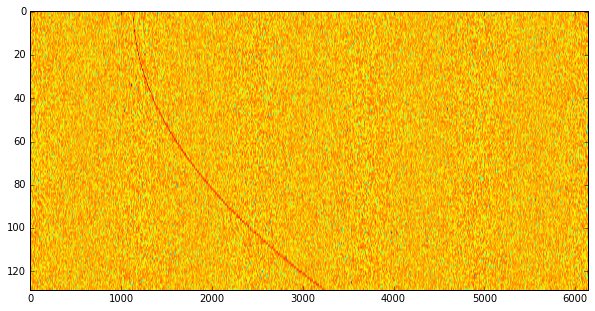

In [141]:
fname = '0329fa9d-1989-4993-8b87-8d689d0482d8.dat'
r = requests.get('{}/{}/{}'.format(base_url, container, fname))
aca = ibmseti.compamp.SimCompamp(r.content)
spec = aca.get_spectrogram()
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])

{u'signal_classification': u'narrowbanddrd', u'uuid': u'08bd4884-1967-45b3-ba1f-cabd3457acf3'}


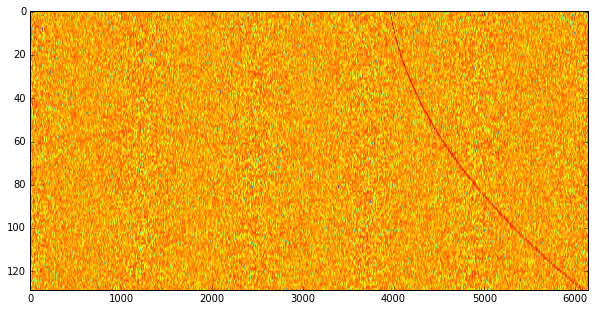

In [142]:
fname = '08bd4884-1967-45b3-ba1f-cabd3457acf3.dat'
r = requests.get('{}/{}/{}'.format(base_url, container, fname))
aca = ibmseti.compamp.SimCompamp(r.content)
print aca.header()
spec = aca.get_spectrogram()
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])

### Narrowband

{u'signal_classification': u'narrowband', u'uuid': u'afcbcdf8-3000-4880-a9fa-23916aa6b15c'}


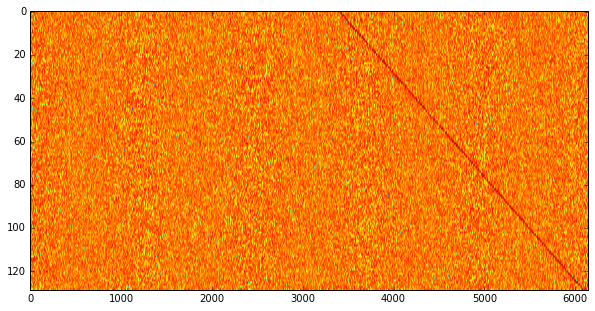

In [143]:
fname = 'afcbcdf8-3000-4880-a9fa-23916aa6b15c.dat'
r = requests.get('{}/{}/{}'.format(base_url, container, fname))
aca = ibmseti.compamp.SimCompamp(r.content)
print aca.header()
spec = aca.get_spectrogram()
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])

Frequency in first chunk, N=0, is around 3500. It will increase as time goes on, and reach to 129th chunck.

### Squiggle

{u'signal_classification': u'squiggle', u'uuid': u'aeb4323c-8034-4483-b934-0efe434fd231'}


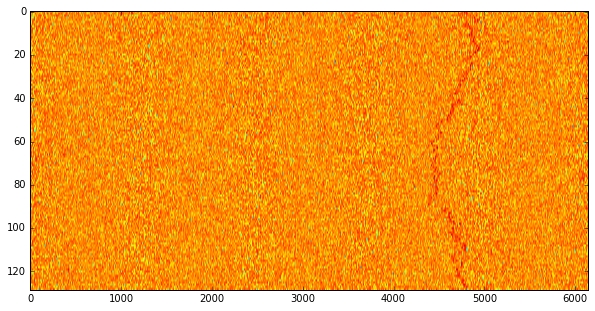

In [144]:
fname = 'aeb4323c-8034-4483-b934-0efe434fd231.dat'
r = requests.get('{}/{}/{}'.format(base_url, container, fname))
aca = ibmseti.compamp.SimCompamp(r.content)
print aca.header()
spec = aca.get_spectrogram()
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])

{u'signal_classification': u'squiggle', u'uuid': u'ad268853-ffb1-4fec-a071-2a046f8b1a8c'}


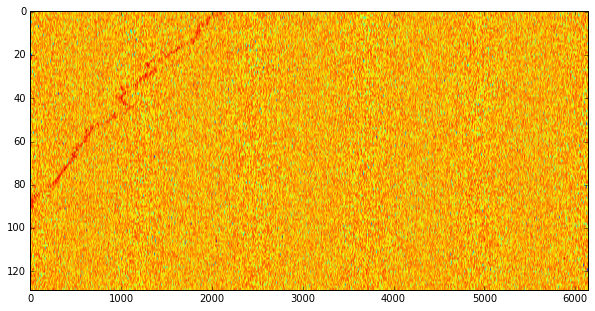

In [145]:
fname = 'ad268853-ffb1-4fec-a071-2a046f8b1a8c.dat'
r = requests.get('{}/{}/{}'.format(base_url, container, fname))
aca = ibmseti.compamp.SimCompamp(r.content)
print aca.header()
spec = aca.get_spectrogram()
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])

# Some notes on playing with the data


### Changing the frequency resolution.

To create a spectrogram, the time-series data are broken up into N samples, each of length, L (such that L x N = Z, where Z is the total number of time-series data points). For each time-series of length L, the DFT is calculated and squared to obtain an estimate of the power of the signal. 

The `aca.get_spectrogram()` method chooses N = 129 and length L = 6144 by default. The data are sized to be exactly equal to the total data size of the files recorded by the SETI Institute. 

However, the size of L can be varied in order to increase the frequency resolution. Do not be confused by the lack of labels on the horizontal axis. __The total frequency range is fixed by the (unknown) sampling frequency of the data.__ Increasing L, just gives you finer frequency resolution within that range. This comes at the expense of decrease the "observation time" along the vertical time-axis in the spectrogram. 

Since the number 129 is only factored by 3, 43, this doesn't give us a lot of room to reshape the signal to different values of N and L. In the examples below, I've cut out the last 6144 samples. This makes the data of Z =  N x L = 128 x 6144, which let's us factor the signal in more ways and doesn't reduce our signal detection capabilities.

In [101]:
import copy
data_redux = copy.copy(aca.complex_data())

# This simply cuts out the last 6144 samples, making data_redux of size 128 * 6144, which can be more easily factored into different shapes
data_redux = data_redux[:-6144]

In [102]:
## PS -- the code below is exactly what aca.get_spectrogram() does for you!

# reshape to get N = 32, L = 24567
data_sh1 = data_redux.reshape(128/4,6144*4)  
power_sh1 = np.abs( np.fft.fftshift( np.fft.fft(data_sh1), 1) )**2 

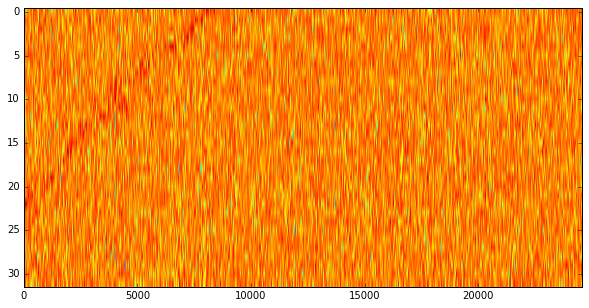

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(power_sh1), aspect = 0.5*float(power_sh1.shape[1]) / power_sh1.shape[0])

You can see the figure above has higher frequency resolution. There are more bins along the (unlabeled) horizontal axis, which still spans the same bandwidth.
The signal is less visible by eye however, because the frequency bins are smaller and thus the total power in each frequency bin is reduced. But, on the other hand, the uncertainty of the measured value of the signal's frequency has decreased by a factor of 4. 

Next I'll **decrease** the frequency resolution (which will also increase the resolution along the vertical time axis)

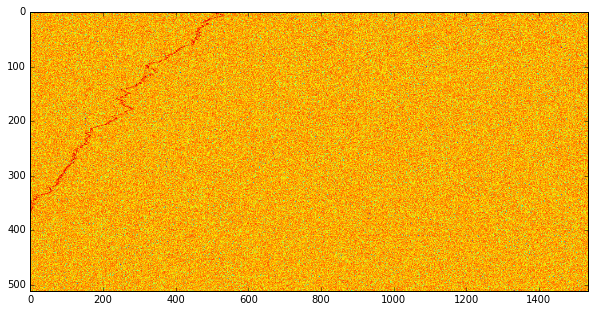

In [64]:
# reshape to get N = 512, L = 1536

data_redux = copy.copy(aca.complex_data())
data_redux = data_redux[:-6144]
data_sh1 = data_redux.reshape(128*4,6144/4)
power_sh1 = np.abs( np.fft.fftshift( np.fft.fft(data_sh1), 1) )**2 
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(power_sh1), aspect = 0.5*float(power_sh1.shape[1]) / power_sh1.shape[0])

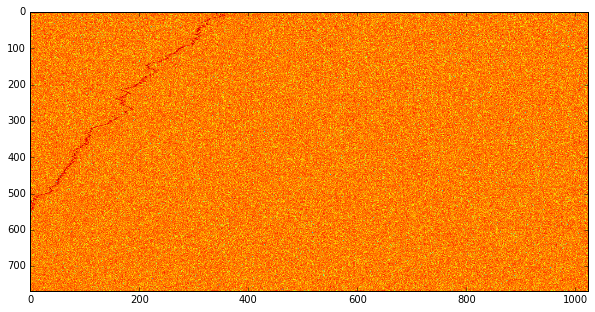

In [63]:
# reshape to get N = 768, L = 1024


data_redux = copy.copy(aca.complex_data())
data_redux = data_redux[:-6144]
data_sh1 = data_redux.reshape(128*6,6144/6)
power_sh1 = np.abs( np.fft.fftshift( np.fft.fft(data_sh1), 1) )**2 
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(power_sh1), aspect = 0.5*float(power_sh1.shape[1]) / power_sh1.shape[0])

### Reducing File Size

I'm going to experiment with file sizes for the simulation code. I may go with smaller files. This means there will simply be a fewer number of time-series samples in each file. 
You can still get (or play around with) the same frequency resolution by reshaping the data as needed.

In [147]:
data_redux = copy.copy(aca.complex_data())

# If I reduce the file size by a ~factor of 4, the simulated data file will be about this size.
data_redux = data_redux[:32*6144]

In [148]:
np.shape(data_redux)

(196608,)

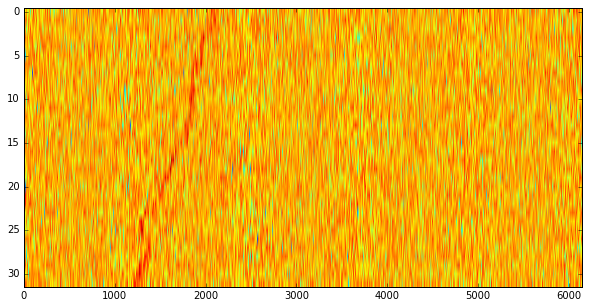

In [74]:
# Perform the standard spectrogram calculation using the 32 * 6144 shape.

data_sh1 = data_redux.reshape(32,6144)
power_sh1 = np.abs( np.fft.fftshift( np.fft.fft(data_sh1), 1) )**2 
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(power_sh1), aspect = 0.5*float(power_sh1.shape[1]) / power_sh1.shape[0])

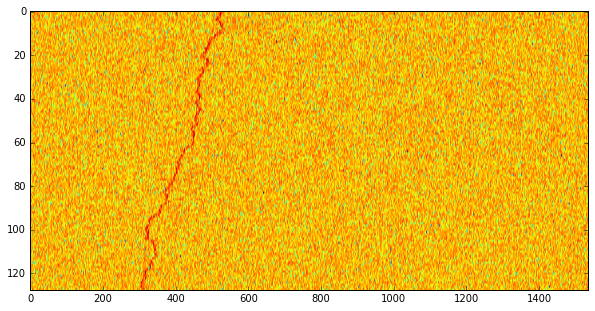

In [75]:
#Here I decrease the frequency resolution by a factor of 4!

# reshape to get N = 128, L = 1536

data_sh1 = data_redux.reshape(32*4,6144/4)
power_sh1 = np.abs( np.fft.fftshift( np.fft.fft(data_sh1), 1) )**2 
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(power_sh1), aspect = 0.5*float(power_sh1.shape[1]) / power_sh1.shape[0])

**Above you see that the file size has been reduce by ~4x, yet there should still be sufficient data to recognize the signal type. **

### Time-Series Pre-processing

The following ideas could be applied to each of the N time-series samples.

#### Windowing

For each sub time-series sample of length L, one could apply various windowing techniques to manipulate the frequency resolution and observable dynamic range! Tukey and Hamming windows would be my first approach. Increasing the dynamic range of observable signals, of course, will be the key to finding and classifying low-amplitude signals. (There are not any low-amplitude signals in the 'basic4' data set, but there are in the primary training and test sets.)

#### Averaging (Welch Periodigram)

Welch's method for estimating the power spectrum could be considered as a way to reduce the variance of the signal (and thereby increasing the observable SNR ratio). 